## Exploration-exploitation tradeoff for the Taxi problem
## Student Marina Grigoreva

This project was done in Jupyter notebook and may not work in Google Colab. If you do not have gym environment on your computer, please uncomment the next cell and run it:

In [1]:
!pip install cmake gym[atari] scipy
!pip install pygame 
!pip stable-baselines3[extra]

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\marus\\AppData\\Local\\Temp\\pip-uninstall-rbsvcd81\\numpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




     -------------------------------------- 14.9/14.9 MB 280.2 kB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3


ERROR: unknown command "stable-baselines3[extra]"



In [ ]:
# import os
# os.environ['SDL_VIDEODRIVER']='dummy'
# import pygame
# pygame.display.set_mode((640,480))

In [52]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

%matplotlib inline

## Problem Statement
### 1. Environment description
1. The map is a `5x5` gridworld.
2. The colors `Red`, `Green`, `Blue`, `Yellow` are 4 locations.
3. A passenger can be at any of the 4 locations.
4. A passenger's destination can be any of the left 3 locations.
5. There are walls and passes
7. The taxi can pass through the pass but not through the wall
8. The environment rewards `20` points when a passenger is dropped to their destination.
9. The environment penalizes `-10` points if pickup operation is performed on a cell where there is no passenger.
10. The environment penalizes `-10` points if drop operation is performed if no passenger had boarded the taxi.
11. The environment penalizes `-1` for every other action.

### 2. Initial conditions
1. At the start, the taxi will be at any of the 25 positions on the map (from `Environment description[1]`).
2. A passenger will be at any of `Red`, `Green`, `Blue`, `Yellow` locations.
3. A destination will be at any of the `Red`, `Green`, `Blue`, `Yellow` locations.

### 3. Expected behaviour
1. The taxi must find the passenger traveling the shortest path.
2. The taxi must pickup the passenger.
3. The taxi must find the shortest path to the passenger's destination.
4. Drop the passenger at their destination traversing the shortest path.

### 4. Actions
There are 6 discrete deterministic actions:

`0`: move south

`1`: move north

`2`: move east

`3`: move west

`4`: pickup passenger

`5`: drop off passenger

## An example of the map:

(-0.5, 549.5, 349.5, -0.5)

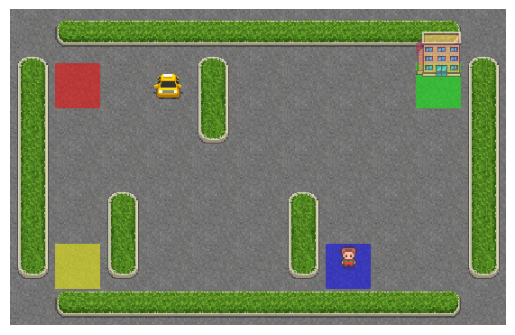

In [342]:
env = gym.make("Taxi-v3", render_mode="rgb_array").env

env.reset() # reset environment to a new, random state
plt.imshow(env.render())
plt.axis('off')

In [51]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


### We can also built a map:

State: 328


(-0.5, 549.5, 349.5, -0.5)

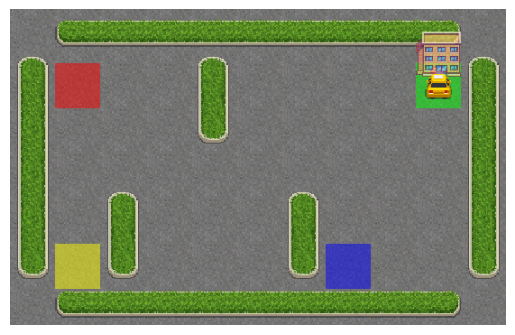

In [368]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
plt.imshow(env.render())
plt.axis('off')

Action Space Discrete(6)
State Space Discrete(500)


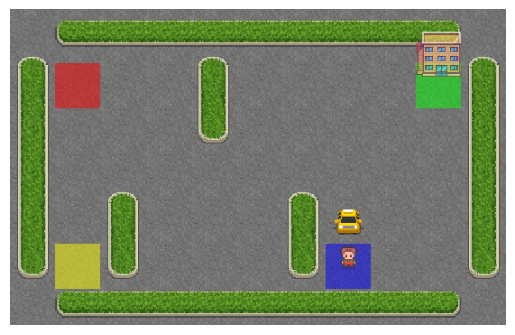

In [369]:
env.reset() # reset environment to a new, random state
plt.imshow(env.render())
plt.axis('off')

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

## Random agent:

Let's see the performance of the random moving taxi (which take a random possible action):

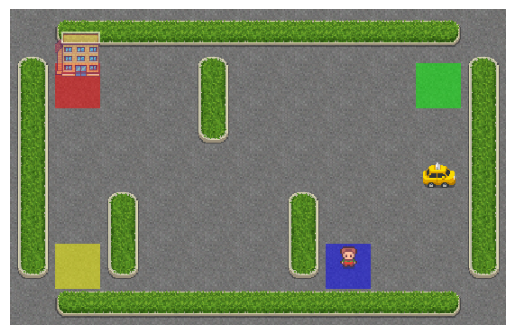

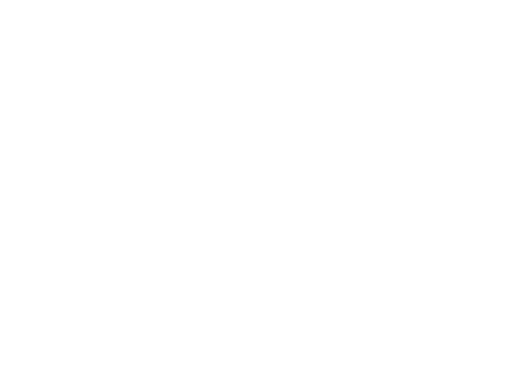

In [210]:
def some_random_games_first():
    # Each of these is its own game.
    for episode in range(5):
        env.reset()
        for t in range(200):
            # This will display the environment
            # Takes much longer to display it.
            # Render the environment at each step
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            plt.axis('off')

            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()

            # this executes the environment with an action,
            # and returns the observation of the environment,
            # the reward, if the env is over, and other info.
            observation, reward, done, truncated, info = env.step(action)
            if done:
                break

some_random_games_first()

Let's see the performance of the random agent:

In [366]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0
cum_rew = 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, _, info = env.step(action)
    cum_rew += reward

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward,
        'cumulative reward': cum_rew
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 322
Penalties incurred: 115


In [367]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        # 
#         plt.imshow(frame['frame'])
#         plt.show()
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Cumulative reward: {frame['cumulative reward']}")
        sleep(.1)
        
print_frames(frames)

Timestep: 322
State: 85
Action: 5
Reward: 20
Cumulative reward: -1336


## $\varepsilon$-greedy strategy:

Let's see the performance of the $\varepsilon$-greedy strategy, meaning choosing random action with probability $\varepsilon$ and action, which minimizes q-table with probability $1-\varepsilon$.

In [350]:
def e_greedy(alpha = 0.5, gamma = 0.9, epsilon = 0.2, num_episodes = 50000, render = False):

    # set up the Taxi problem environment
    env = gym.make('Taxi-v3', render_mode="rgb_array")

    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    total_rewards = 0
    total_completion_time = 0
    total_successes = 0
    episode_rewards = []
    completion_time = []
    avg_rewards = []
    avg_times = []
    
    # initialize Q-table
    qtable = -5*np.ones((state_size, action_size))

    # set hyperparameters
    max_steps = 1000

    for episode in range(num_episodes):

        # reset the environment
        state, _ = env.reset()
        done = False
        episode_reward = 0
        max_episode_reward = 0
        episode_steps = 0
        
        while episode_steps < max_steps and not done:

            # exploration-exploitation tradeoff
            if random.uniform(0,1) < epsilon:
                # explore
                action = env.action_space.sample()
            else:
                # exploit
                action = np.argmax(qtable[state,:])

            # take action and observe reward
            new_state, reward, done, _, info = env.step(action)

            # Q-learning algorithm
            qtable[state,action] += alpha * (reward + gamma * np.max(qtable[new_state,:]) - qtable[state,action])

            # Update to our new state
            episode_reward += reward
            episode_steps += 1
            state = new_state
            
            if done:
                # save final episode reward
                episode_rewards.append(episode_reward)
                completion_time.append(episode_steps)
                max_episode_reward = reward
                break
                
        if (episode >= 100):
            # get average reward from the last 100 episodes
            avg_reward = np.mean(episode_rewards[episode-100:episode+1])
            avg_time = np.mean(completion_time[episode-100:episode+1])
            # append to the lists
            avg_rewards.append(avg_reward)
            avg_times.append(avg_time)
            
        total_rewards += episode_reward
        total_completion_time += episode_steps

        if max_episode_reward == 20:  # Success if total rewards equal to maximum possible rewards
            total_successes += 1
        
    average_rewards = total_rewards / num_episodes
    average_completion_time = total_completion_time / num_episodes
    success_rate = total_successes / num_episodes
    
    env.close()
    if render:
        return qtable
    else:
        return avg_rewards, avg_times, average_rewards, average_completion_time, success_rate

For epsilon value 0 average reward is 4.6935, average completion time is 15.255, success rate is 0.9999
For epsilon value 0.001 average reward is 4.5581, average completion time is 15.3349, success rate is 0.9997
For epsilon value 0.01 average reward is 4.0563, average completion time is 15.4452, success rate is 0.9997
For epsilon value 0.1 average reward is -1.3185, average completion time is 16.9404, success rate is 0.9998


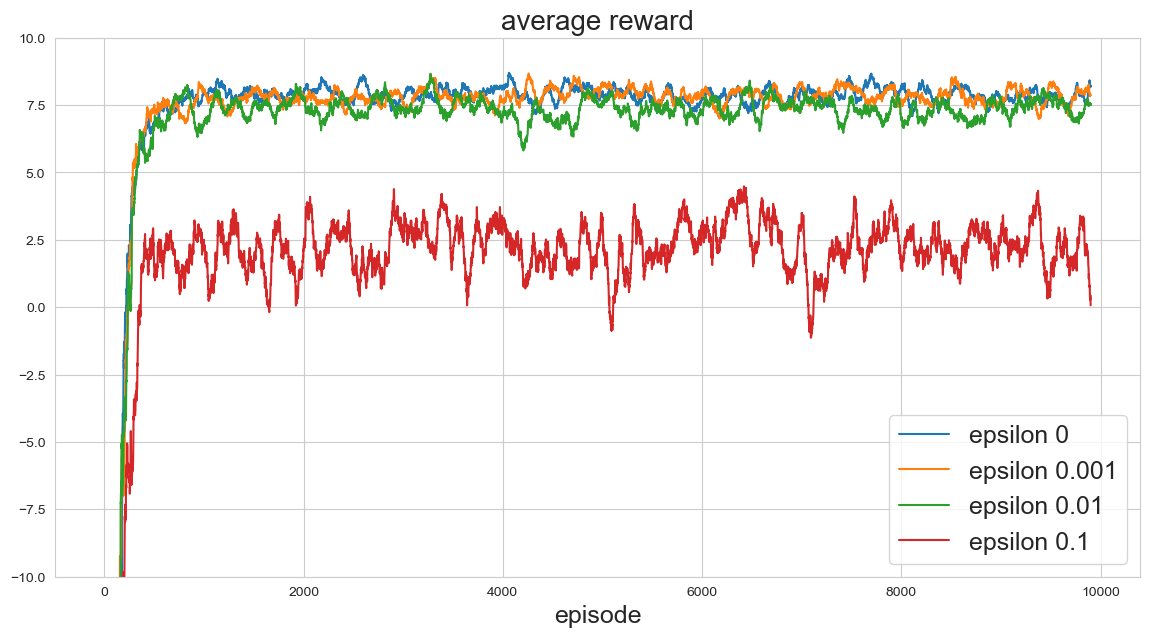

In [344]:
eps = [0, 0.001, 0.01, 0.1]

rewards = []
completion_time = []
success = []
num_episodes = 10000

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
for e in eps:
    episode_rewards, time, average_rewards, average_completion_time, success_rate = e_greedy(alpha = 0.5, 
                                                                                             gamma = 0.9, 
                                                                                             epsilon = e, 
                                                                                             num_episodes = num_episodes)
    
    ax.set_title(f"average reward", fontsize=20)
    ax.plot(range(len(episode_rewards)), episode_rewards, '-', label = f'epsilon {e}')
    ax.legend(fontsize=18)
    ax.set_xlabel("episode", fontsize=18)
    ax.set_ylim(-10, 10)
    print(f'For epsilon value {e} average reward is {average_rewards}, average completion time is {average_completion_time}, success rate is {success_rate}')

Let's also try to change the initial $Q$-table and put there negative values (here I used $-5$):

For epsilon value 0 average reward is 5.1212, average completion time is 15.1798, success rate is 0.9998
For epsilon value 0.001 average reward is 4.971, average completion time is 15.2913, success rate is 0.9998
For epsilon value 0.01 average reward is 4.5075, average completion time is 15.3822, success rate is 0.9998
For epsilon value 0.1 average reward is -1.3032, average completion time is 17.067, success rate is 0.9997


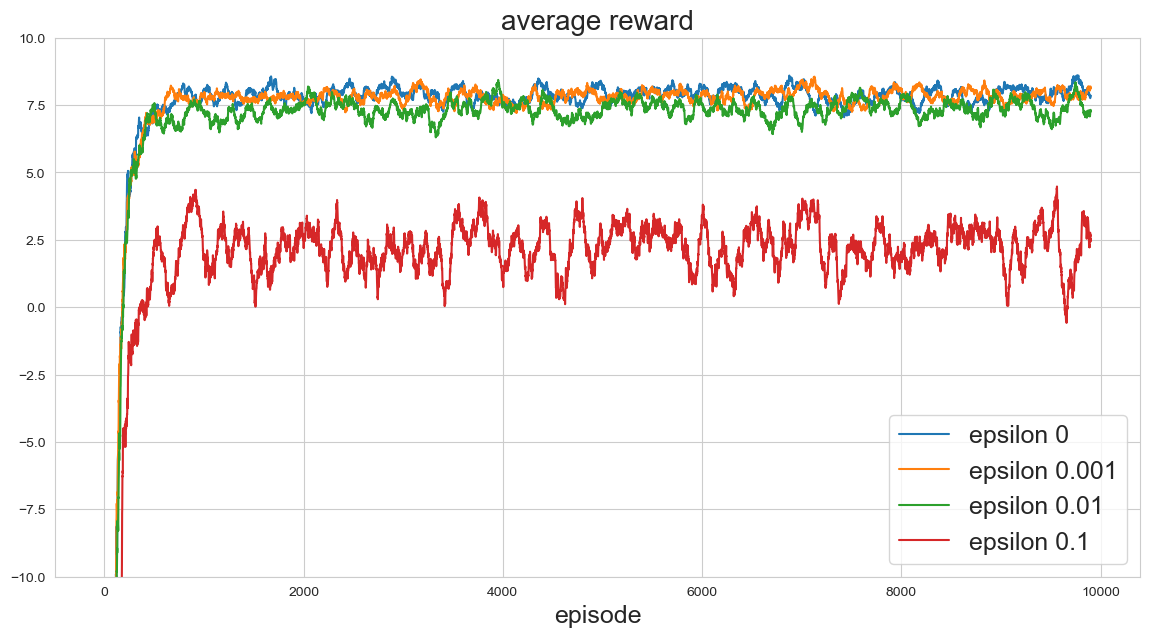

In [346]:
eps = [0, 0.001, 0.01, 0.1]

rewards = []
completion_time = []
success = []
num_episodes = 10000

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
for e in eps:
    episode_rewards, time, average_rewards, average_completion_time, success_rate = e_greedy(alpha = 0.5, 
                                                                                             gamma = 0.9, 
                                                                                             epsilon = e, 
                                                                                             num_episodes = num_episodes)
    
    ax.set_title(f"average reward", fontsize=20)
    ax.plot(range(len(episode_rewards)), episode_rewards, '-', label = f'epsilon {e}')
    ax.legend(fontsize=18)
    ax.set_xlabel("episode", fontsize=18)
    ax.set_ylim(-10, 10)
    print(f'For epsilon value {e} average reward is {average_rewards}, average completion time is {average_completion_time}, success rate is {success_rate}')

In [249]:
def evaluation(q_table, num_episodes = 100, render = True):

    # set up the Taxi problem environment
    env = gym.make('Taxi-v3', render_mode="rgb_array")
    
    total_reward = 0
    total_completion_time = 0
    average_reward = 0
    average_completion_time = 0
    max_steps = 100
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        if render:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            plt.axis('off')
        done = False
        episode_rewards = 0
        episode_steps = 0

        while not done and episode_steps < max_steps:
            action = np.argmax(q_table[state, :])
            new_state, reward, done, _, info = env.step(action)
            
            if render:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
                plt.axis('off')
            episode_rewards += reward
            episode_steps += 1
            if render:
                print(f'Current reward of the step: {reward}')
                print(f'Current episode reward: {episode_rewards}')
                print(f'Current step: {episode_steps}')
                print(f'Average reward: {average_reward}')
                print(f'Average completition time: {average_completion_time}')
            state = new_state

        total_reward += episode_rewards
        average_reward = total_reward / (episode + 1)
        
        total_completion_time += episode_steps
        average_completion_time = total_completion_time / (episode + 1)

    return average_reward, average_completion_time

### Performance:

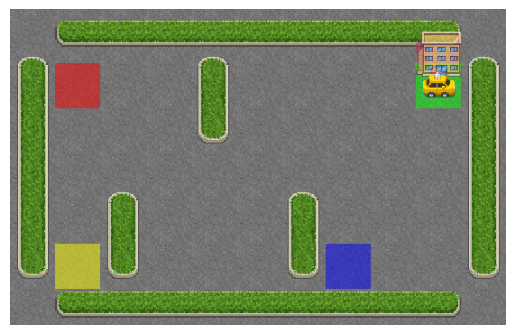

Current reward of the step: 20
Current episode reward: 6
Current step: 15
Average reward: 7.787878787878788
Average completition time: 13.212121212121213


(7.77, 13.23)

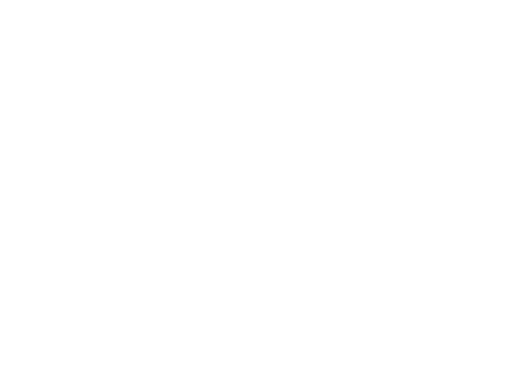

In [266]:
q_table = e_greedy(alpha = 0.5, gamma = 0.9, epsilon = 0.001, num_episodes = 10000, render = True)
evaluation(q_table)

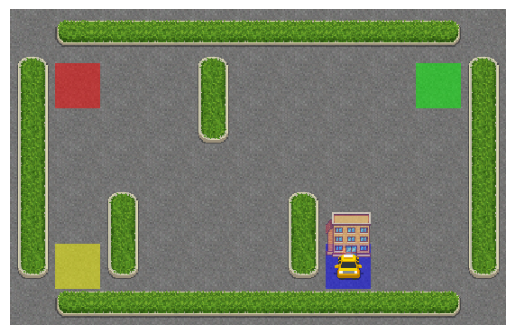

Current reward of the step: 20
Current episode reward: 8
Current step: 13
Average reward: 7.878787878787879
Average completition time: 13.121212121212121


(7.88, 13.12)

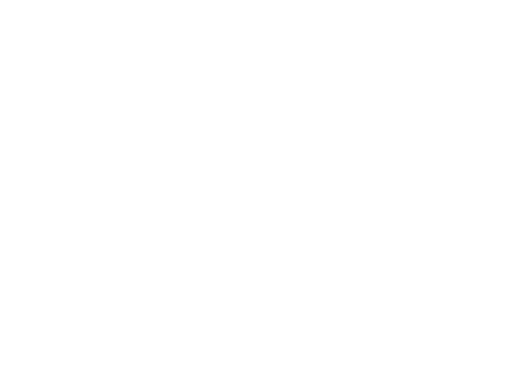

In [351]:
q_table = e_greedy(alpha = 0.5, gamma = 0.9, epsilon = 0.001, num_episodes = 10000, render = True)
evaluation(q_table)

### $\varepsilon$-greedy algorithm with decay rate:

Let's also try the $\varepsilon$-greedy algorithm where parameter $\varepsilon$ decreases. In the begginning of learning the agent need to try as more new actions as possible, to gather more information about the environment and improve its understanding of the state-action space. The more an agent learns about the environment, the better action choices it will make later on, so it is more important to increase the probability of choosing strategies that have already been tested. By decreasing the $\varepsilon$ value, the agent shifts its focus from exploration to exploitation, allowing it to converge towards an optimal policy.

In [336]:
def e_greedy_decay(alpha = 0.5, gamma = 0.9, epsilon = 0.5, decay = 0.999, num_episodes = 50000, render = False):

    # set up the Taxi problem environment
    env = gym.make('Taxi-v3', render_mode="rgb_array")

    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    total_rewards = 0
    total_completion_time = 0
    total_successes = 0
    episode_rewards = []
    completion_time = []
    avg_rewards = []
    avg_times = []
    
    # initialize Q-table
    qtable = -5*np.ones((state_size, action_size))

    # set hyperparameters
    epsilon_value = epsilon
    decay_rate = decay
    max_steps = 1000

    for episode in range(num_episodes):

        # reset the environment
        state, _ = env.reset()
        done = False
        episode_reward = 0
        max_episode_reward = 0
        episode_steps = 0
        
        while episode_steps < max_steps and not done:

            # exploration-exploitation tradeoff
            if random.uniform(0,1) < epsilon_value:
                # explore
                action = env.action_space.sample()
            else:
                # exploit
                action = np.argmax(qtable[state,:])

            # take action and observe reward
            new_state, reward, done, _, info = env.step(action)

            # Q-learning algorithm
            qtable[state,action] += alpha * (reward + gamma * np.max(qtable[new_state,:]) - qtable[state,action])

            # Update to our new state
            episode_reward += reward
            episode_steps += 1
            state = new_state
            
            if done:
                # save final episode reward
                episode_rewards.append(episode_reward)
                completion_time.append(episode_steps)
                max_episode_reward = reward
                break
                
        if (episode >= 100):
            # get average reward from the last 100 episodes
            avg_reward = np.mean(episode_rewards[episode-100:episode+1])
            avg_time = np.mean(completion_time[episode-100:episode+1])
            # append to the lists
            avg_rewards.append(avg_reward)
            avg_times.append(avg_time)
            
        total_rewards += episode_reward
        total_completion_time += episode_steps

        if max_episode_reward == 20:  # Success if total rewards equal to maximum possible rewards
            total_successes += 1

        # Decrease epsilon
        epsilon_value *= decay_rate
        epsilon_value = max(0.0001, epsilon_value)
        
    average_rewards = total_rewards / num_episodes
    average_completion_time = total_completion_time / num_episodes
    success_rate = total_successes / num_episodes
    
    env.close()
    if render:
        return qtable
    else:
        return avg_rewards, avg_times, average_rewards, average_completion_time, success_rate

For epsilon 0 and decay 0.9999 average reward is 5.0747, average completion time is 15.2239, success rate is 0.9999
For epsilon 0.001 and decay 0.9999 average reward is 5.0016, average completion time is 15.2706, success rate is 0.9998
For epsilon 0.01 and decay 0.9999 average reward is 4.7025, average completion time is 15.3267, success rate is 0.9998
For epsilon 0.1 and decay 0.9999 average reward is 0.8034, average completion time is 16.5519, success rate is 0.9998
For epsilon 0 and decay 0.999 average reward is 5.0672, average completion time is 15.2284, success rate is 0.9998
For epsilon 0.001 and decay 0.999 average reward is 5.0817, average completion time is 15.2112, success rate is 0.9998
For epsilon 0.01 and decay 0.999 average reward is 4.9618, average completion time is 15.2597, success rate is 0.9997
For epsilon 0.1 and decay 0.999 average reward is 3.9637, average completion time is 15.4625, success rate is 0.9998
For epsilon 0 and decay 0.99 average reward is 5.0336, ave

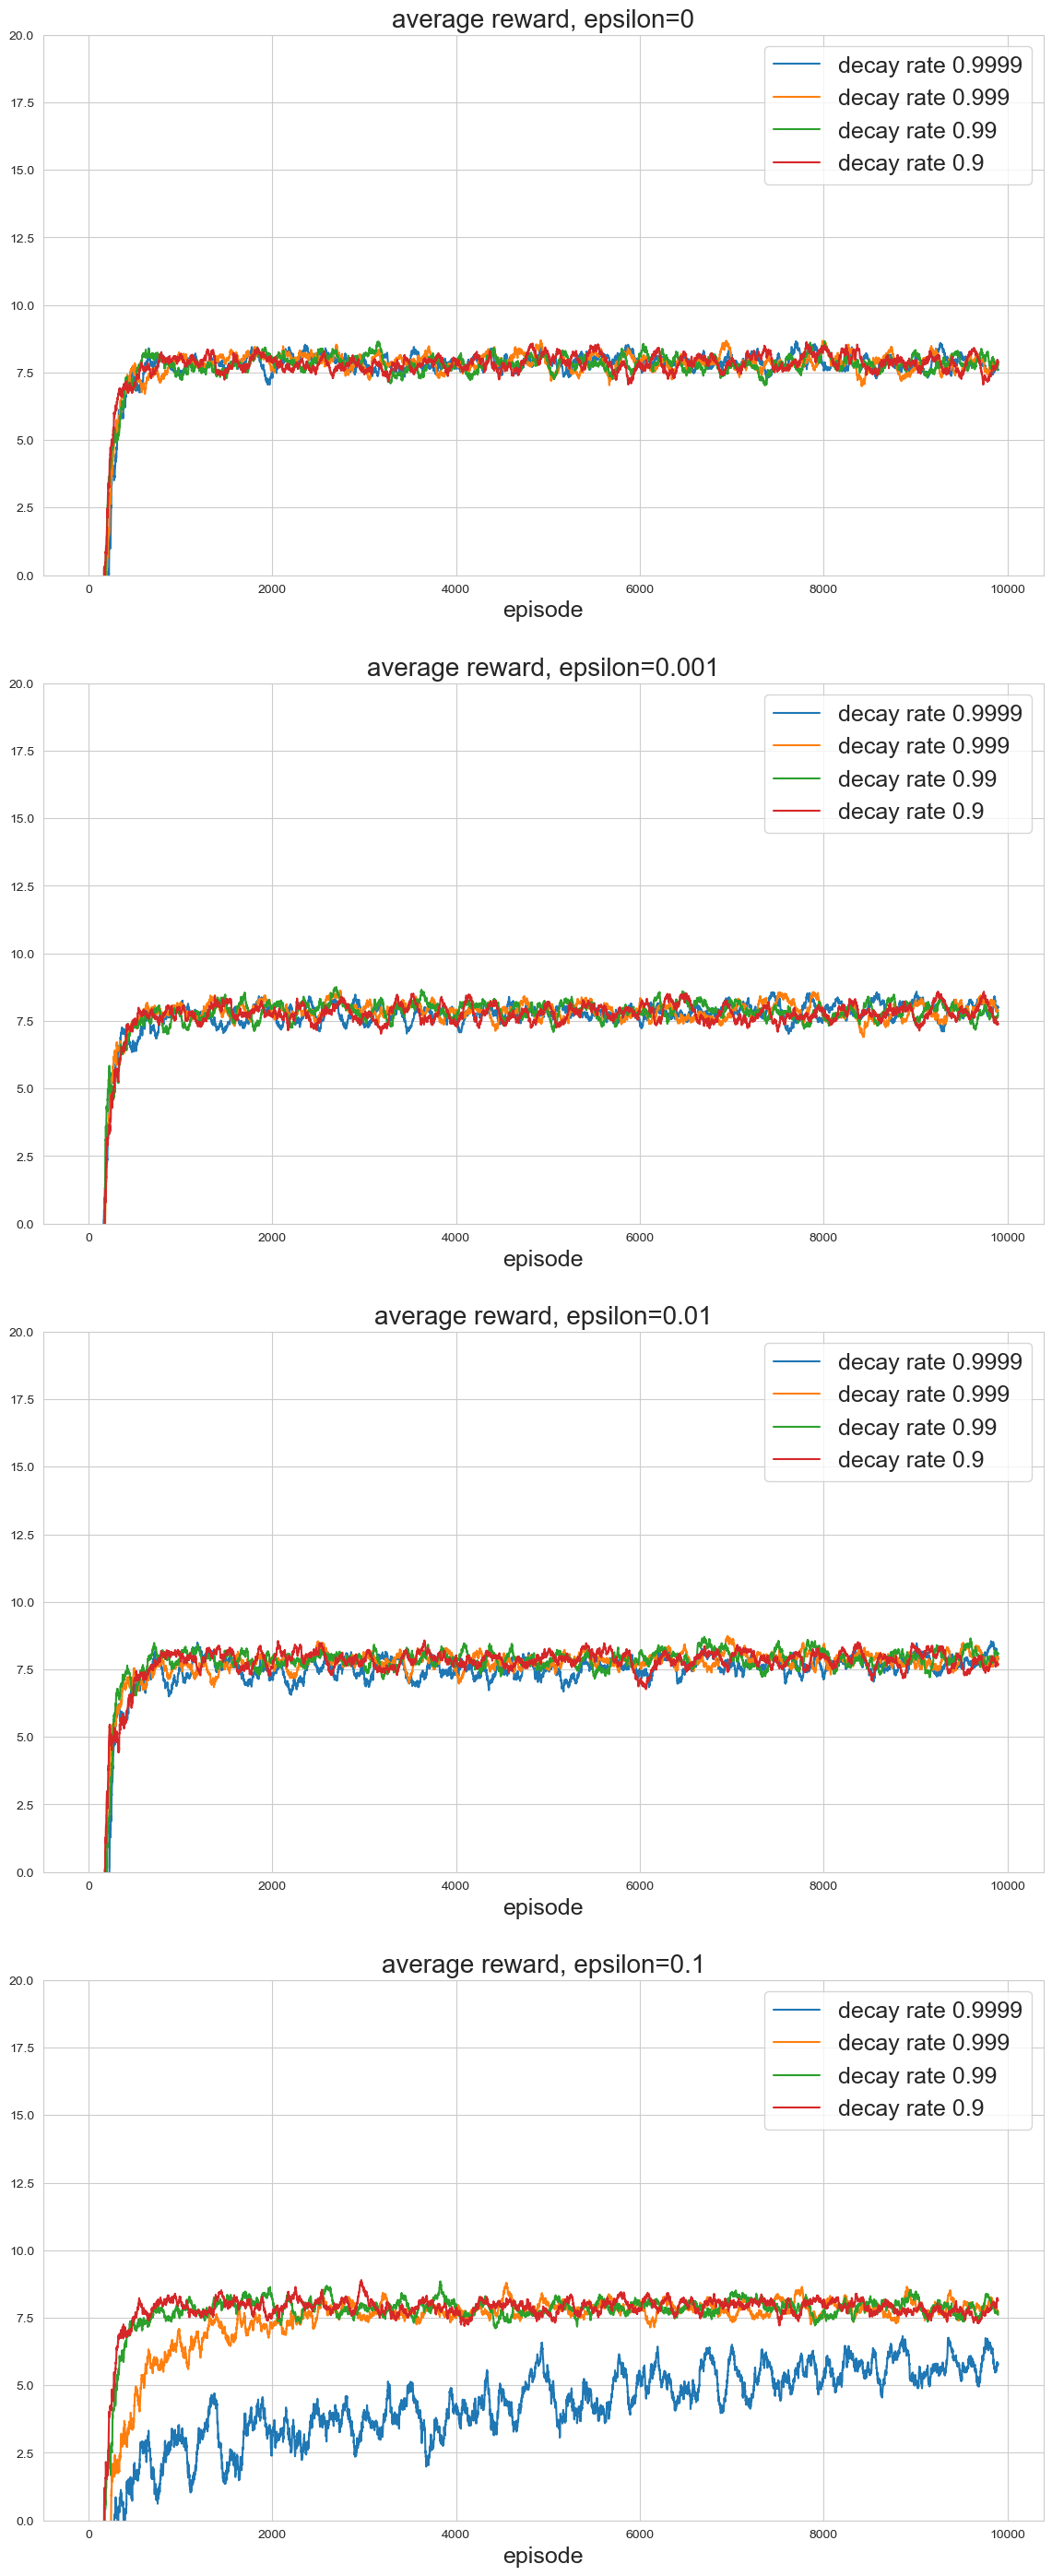

In [322]:
eps = [0, 0.001, 0.01, 0.1]
dec = [0.9999, 0.999, 0.99, 0.9]

rewards = []
completion_time = []
success = []
num_episodes = 10000

sns.set_style('whitegrid')
fig, ax = plt.subplots(4, 1, figsize=(14, 35))
for d in dec:
    for e, axs in zip(eps, ax):
        episode_rewards, time, average_rewards, average_completion_time, success_rate = e_greedy_decay(alpha = 0.5, 
                                                                                                 gamma = 0.9, 
                                                                                                 epsilon = e, 
                                                                                                 decay = d,
                                                                                                 num_episodes = num_episodes)

        axs.set_title(f"average reward, epsilon={e}", fontsize=20)
        axs.plot(range(len(episode_rewards)), episode_rewards, '-', label = f'decay rate {d}')
        axs.legend(fontsize=18)
        axs.set_xlabel("episode", fontsize=18)
        axs.set_ylim(0, 20)
        print(f'For epsilon {e} and decay {d} average reward is {average_rewards}, average completion time is {average_completion_time}, success rate is {success_rate}')

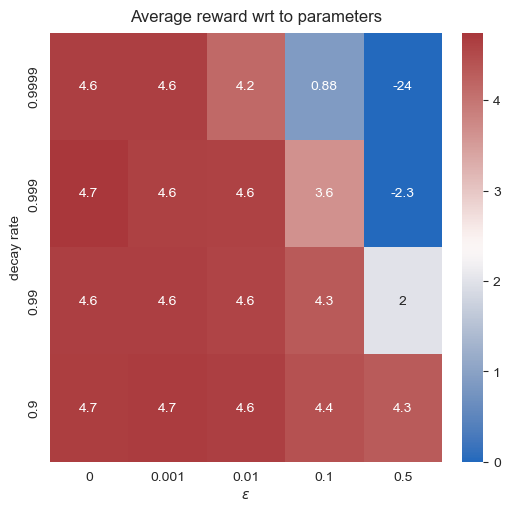

In [275]:
eps = [0, 0.001, 0.01, 0.1, 0.5]
dec = [0.9999, 0.999, 0.99, 0.9]

rewards = []
num_episodes = 10000

fig, axs = plt.subplots(1, 1, layout="constrained", figsize=(5, 5), sharey=True)

fig.suptitle("Average reward wrt to parameters")

cmap = sns.color_palette("vlag", as_cmap=True)

for d in dec:
    for e in eps:
        episode_rewards, time, average_rewards, average_completion_time, success_rate = e_greedy_decay(alpha = 0.5, 
                                                                                                 gamma = 0.9, 
                                                                                                 epsilon = e, 
                                                                                                 decay = d,
                                                                                                 num_episodes = num_episodes)
        rewards.append(average_rewards)

Z = np.array(rewards).reshape(4, 5)

sns.heatmap(Z, cmap=cmap, annot=True, vmin=0, vmax=np.max(Z), ax=axs, xticklabels=eps, yticklabels=dec)
axs.set_xlabel(r'$\varepsilon$')
axs.set_ylabel('decay rate')
    
plt.show()

### Performance:

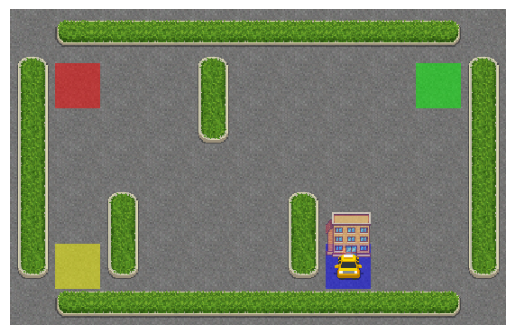

Current reward of the step: 20
Current episode reward: 6
Current step: 15
Average reward: 8.171717171717171
Average completition time: 12.828282828282829


(8.15, 12.85)

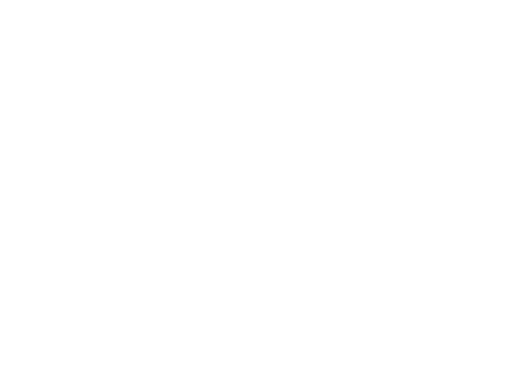

In [360]:
q_table = e_greedy_decay(alpha = 0.5, gamma = 0.9, epsilon = 0.001, num_episodes = 10000, render = True)
rendering(q_table)

## UCB strategy:

In [361]:
def UCB(c = 1.0, num_episodes = 50000, render = False):

    # set up the Taxi problem environment
    env = gym.make('Taxi-v3', render_mode="rgb_array")

    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    total_rewards = 0
    total_completion_time = 0
    total_successes = 0
    episode_rewards = []
    completion_time = []
    avg_rewards = []
    avg_times = []
    
    # initialize Q-table
    qtable = np.zeros((state_size, action_size))
    n_visits = np.zeros((state_size, action_size))

    # set hyperparameters
    max_steps = 1000

    for episode in range(num_episodes):

        # reset the environment
        state, _ = env.reset()
        done = False
        episode_reward = 0
        max_episode_reward = 0
        episode_steps = 0
        
        while episode_steps < max_steps:

            ucb_values = qtable[state, :] + c * np.sqrt(np.log(episode + 1) / (n_visits[state, :] + 1e-6))
            action = np.argmax(ucb_values)  # Exploit learned values

            # take action and observe reward
            new_state, reward, done, _, info = env.step(action)

            # Q-learning algorithm
            qtable[state,action] += (1 / (n_visits[state, action] + 1)) * (reward + np.max(qtable[new_state, :])-qtable[state,action])
            n_visits[state, action] += 1
            
            # Update to our new state
            episode_reward += reward
            episode_steps += 1
            state = new_state
            
            if done:
                # save final episode reward
                episode_rewards.append(episode_reward)
                completion_time.append(episode_steps)
                max_episode_reward = reward
                break
                
        if (episode >= 100):
            # get average reward from the last 100 episodes
            avg_reward = np.mean(episode_rewards[-100:])
            avg_time = np.mean(completion_time[-100:])
            # append to the lists
            avg_rewards.append(avg_reward)
            avg_times.append(avg_time)
            
        total_rewards += episode_reward
        total_completion_time += episode_steps

        if max_episode_reward == 20:  # Success if total rewards equal to maximum possible rewards
            total_successes += 1
        
    average_rewards = total_rewards / num_episodes
    average_completion_time = total_completion_time / num_episodes
    success_rate = total_successes / num_episodes
    
    env.close()
    if render:
        return qtable
    else:
        return avg_rewards, avg_times, average_rewards, average_completion_time, success_rate

For c value 0 average reward is 4.42806, average completion time is 16.50204, success rate is 0.99998
For c value 0.5 average reward is 3.13819, average completion time is 17.79128, success rate is 0.99995
For c value 1 average reward is 2.41598, average completion time is 18.49603, success rate is 0.99995
For c value 5 average reward is -0.05307, average completion time is 20.77791, success rate is 0.99996
For c value 10 average reward is -2.97703, average completion time is 23.20549, success rate is 0.99995


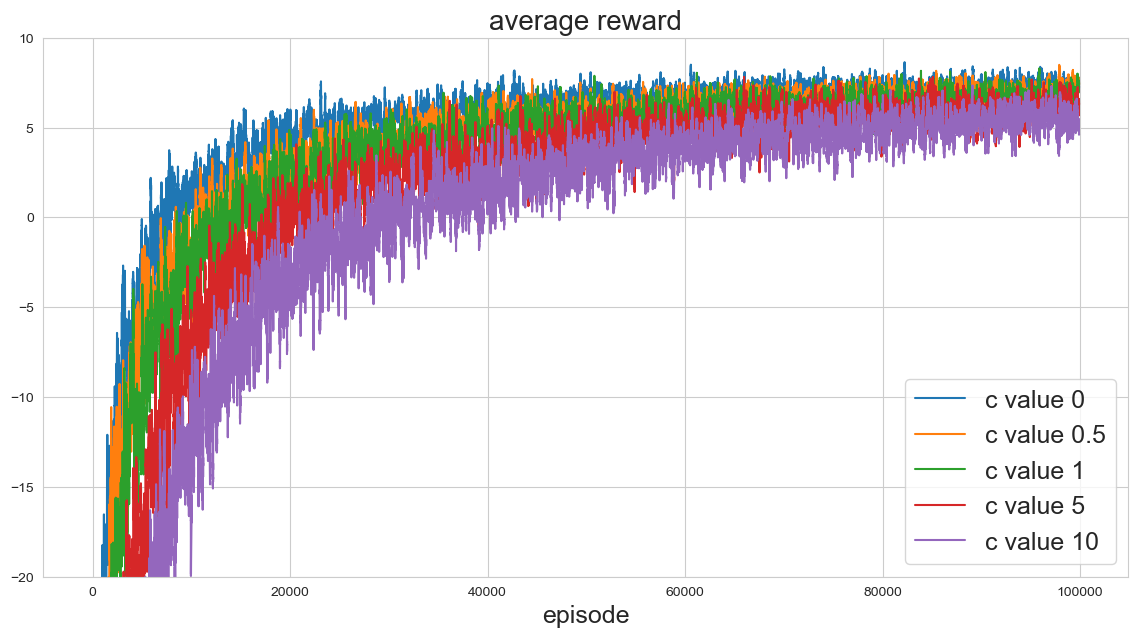

In [359]:
c_value = [0, 0.5, 1, 5, 10]

num_episodes = 100000

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for c_ in c_value:
    episode_rewards, time, average_rewards, average_completion_time, success_rate = UCB(c = c_,
                                                                                        num_episodes = num_episodes)
    ax.set_title(f"average reward", fontsize=20)
    ax.plot(range(len(episode_rewards)), episode_rewards, '-', label = f'c value {c_}')
    ax.legend(fontsize=18)
    ax.set_xlabel("episode", fontsize=18)
    ax.set_ylim(-20, 10)
    print(f'For c value {c_} average reward is {average_rewards}, average completion time is {average_completion_time}, success rate is {success_rate}')

Let's also try to set the $Q$-table equation as it was in $\varepsilon$-greedy algorithm:

In [362]:
def UCB_(c = 1.0, num_episodes = 50000, render = False):

    # set up the Taxi problem environment
    env = gym.make('Taxi-v3', render_mode="rgb_array")

    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    total_rewards = 0
    total_completion_time = 0
    total_successes = 0
    episode_rewards = []
    completion_time = []
    avg_rewards = []
    avg_times = []
    epsilon = 0.01
    
    # initialize Q-table
    qtable = np.zeros((state_size, action_size))
    n_visits = np.zeros((state_size, action_size))

    # set hyperparameters
    max_steps = 1000

    for episode in range(num_episodes):

        # reset the environment
        state, _ = env.reset()
        done = False
        episode_reward = 0
        max_episode_reward = 0
        episode_steps = 0
        
        while episode_steps < max_steps:
            
            ucb_values = qtable[state, :] + c * np.sqrt(np.log(episode + 1) / (n_visits[state, :] + 1e-6))
            action = np.argmax(ucb_values)  # Exploit learned values

            # take action and observe reward
            new_state, reward, done, _, info = env.step(action)

            # Q-learning algorithm
            qtable[state, action] += 0.5 * (reward + 0.9 * np.max(qtable[new_state, :]) - qtable[state, action])
            n_visits[state, action] += 1
            
            # Update to our new state
            episode_reward += reward
            episode_steps += 1
            state = new_state
            
            if done:
                # save final episode reward
                episode_rewards.append(episode_reward)
                completion_time.append(episode_steps)
                max_episode_reward = reward
                break
                
        if (episode >= 100):
            # get average reward from the last 100 episodes
            avg_reward = np.mean(episode_rewards[-100:])
            avg_time = np.mean(completion_time[-100:])
            # append to the lists
            avg_rewards.append(avg_reward)
            avg_times.append(avg_time)
            
        total_rewards += episode_reward
        total_completion_time += episode_steps

        if max_episode_reward == 20:  # Success if total rewards equal to maximum possible rewards
            total_successes += 1
        
    average_rewards = total_rewards / num_episodes
    average_completion_time = total_completion_time / num_episodes
    success_rate = total_successes / num_episodes
    
    env.close()
    if render:
        return qtable
    else:
        return avg_rewards, avg_times, average_rewards, average_completion_time, success_rate

For c value 0 average reward is 4.6338, average completion time is 15.3072, success rate is 0.9998
For c value 0.5 average reward is 4.4541, average completion time is 15.36, success rate is 0.9998
For c value 1 average reward is 4.2832, average completion time is 15.4904, success rate is 0.9998
For c value 5 average reward is 3.1286, average completion time is 15.8236, success rate is 0.9999
For c value 10 average reward is -0.8085, average completion time is 18.3516, success rate is 0.9997


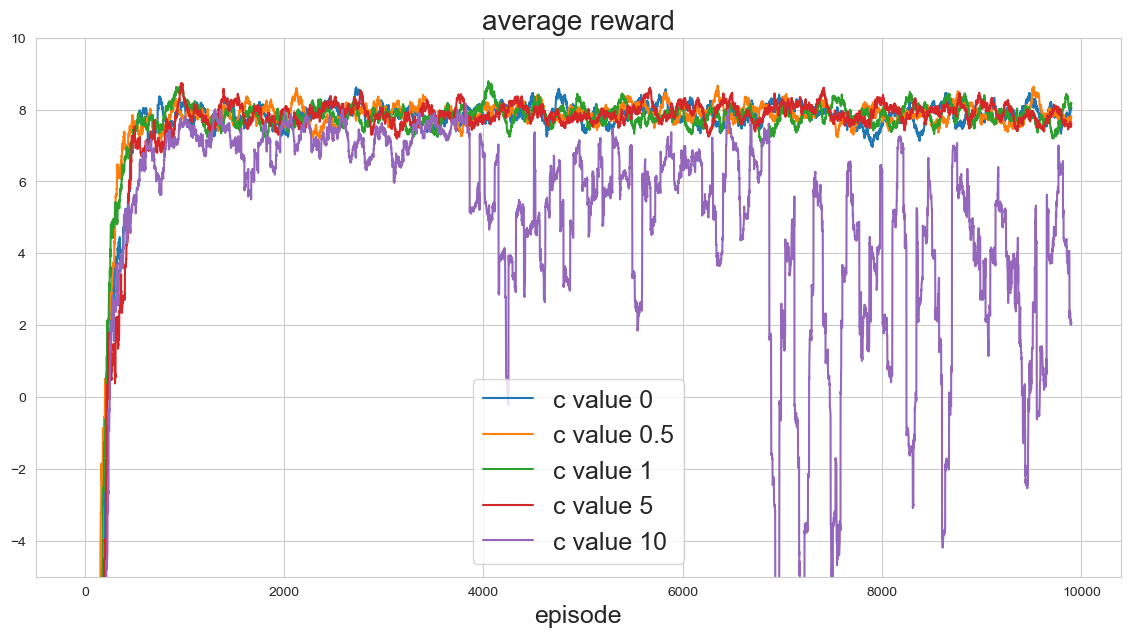

In [357]:
c_value = [0, 0.5, 1, 5, 10]

num_episodes = 10000

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for c_ in c_value:
    episode_rewards, time, average_rewards, average_completion_time, success_rate = UCB_(c = c_,
                                                                                        num_episodes = num_episodes)
    ax.set_title(f"average reward", fontsize=20)
    ax.plot(range(len(episode_rewards)), episode_rewards, '-', label = f'c value {c_}')
    ax.legend(fontsize=18)
    ax.set_xlabel("episode", fontsize=18)
    ax.set_ylim(-5, 10)
    print(f'For c value {c_} average reward is {average_rewards}, average completion time is {average_completion_time}, success rate is {success_rate}')

### Performance:

First UCB:

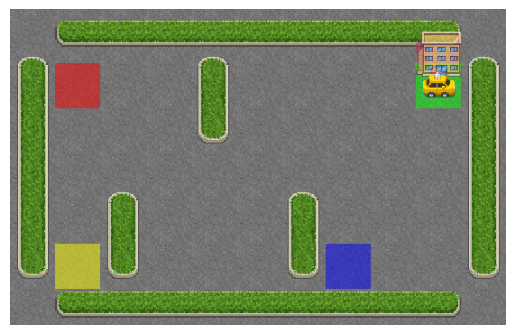

Current reward of the step: 20
Current episode reward: 7
Current step: 14
Average reward: 7.91919191919192
Average completition time: 13.080808080808081


(7.91, 13.09)

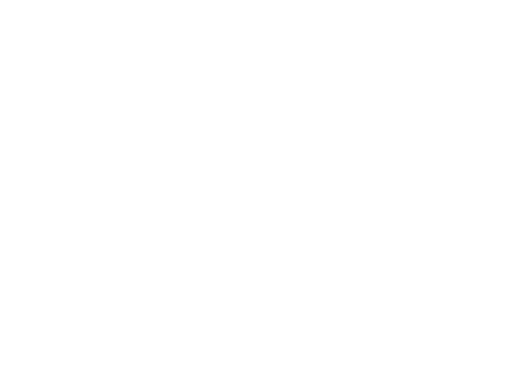

In [364]:
q_table = UCB(c = 0.5, num_episodes = 100000, render = True)
evaluation(q_table)

Second UCB:

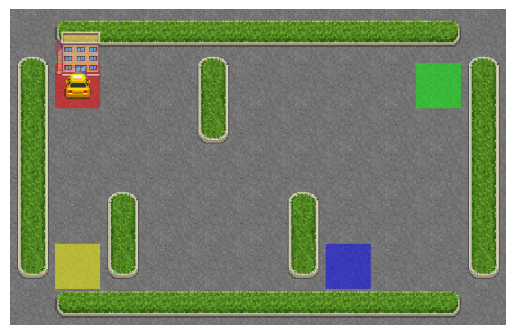

Current reward of the step: 20
Current episode reward: 7
Current step: 14
Average reward: 8.171717171717171
Average completition time: 12.828282828282829


(8.16, 12.84)

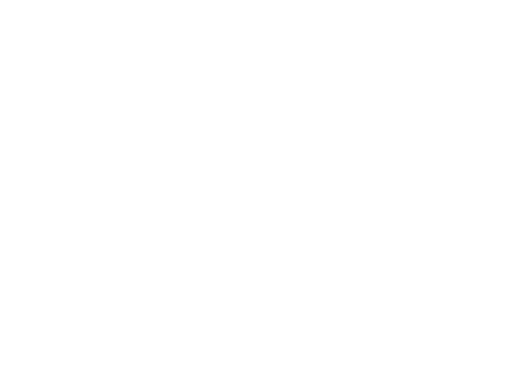

In [363]:
q_table = UCB_(c = 0.5, num_episodes = 10000, render = True)
evaluation(q_table)